## Import libraries

In [4]:
import os
import math
import json
import folium
import pickle
import warnings
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from numpy import cos, sin, arcsin, sqrt
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from yellowbrick.cluster import InterclusterDistance
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
warnings.simplefilter(action='ignore', category=Warning)
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
plt.figure(figsize=(20,5))

PALETTE_DEG = ["FF"]
PALETTE = ["#FFC30D", "#EF404B"]
PALETTE_ALT = ["#40EFE4", "#EF404B"]

R = 6371
KMS_AROUND = 3.20
WINDOW_TIME = 3.12

<Figure size 1440x360 with 0 Axes>

In [5]:
df = pd.read_pickle("../data/shippify_icd_task_new.pkl", compression='gzip')
df['delta'] = (df.delivery_dt - df.delivery_effective).dt.total_seconds() / 3600

## Utils functions

In [6]:
def set_labels(title=None, x_label=None, y_label=None, fontsize=14, legend=None):
  if title is not None:
    plt.title(title, fontsize=fontsize)
  if x_label is not None:
    plt.xlabel(x_label, fontsize=fontsize)
  if y_label is not None:
    plt.ylabel(y_label, fontsize=fontsize)
  if legend is not None:
    legend['object'].set_title(legend['title'])
    for t, l in zip(legend['object'].texts, legend['texts']): t.set_text(l)

def with_hue(plot, feature, categories, hue_categories, diff=False):
  a = [p.get_height() for p in plot.patches]
  patch = [p for p in plot.patches]
  differences = {'class': [], 'value': []}
  for i in range(categories):
    total = a[i] + a[i+categories]
    difference = []
    for j in range(hue_categories):
      value = round(100 * a[(j*categories + i)]/total, 2)
      percentage = '{:.1f}%'.format(value)
      x = patch[(j*categories + i)].get_x() + patch[(j*categories + i)].get_width() / 2 - 0.15
      y = patch[(j*categories + i)].get_y() + patch[(j*categories + i)].get_height() 
      plt.annotate(percentage, (x, y), size = 12)
      if diff:
        difference.append(value)
    if diff:
      diff_value = abs(round(difference[0]-difference[1], 2))
      differences['class'].append(feature[i])
      differences['value'].append(diff_value)
      print('{0:16s}: |{1:>5} - {2:>5}| = {3:>5}'.format(feature[i], difference[0], difference[1], diff_value))
    #print(f'{feature[i]}: {difference[0]} - {difference[1]} = {abs(round(difference[0]-difference[1], 2))}')
  plt.show()
  if diff:
    return pd.DataFrame.from_dict(differences)
  
class display(object):
  """Display HTML representation of multiple objects"""
  template = """<div style="float: left; padding: 10px;">
  <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
  </div>"""
  def __init__(self, *args):
    self.args = args

  def _repr_html_(self):
    return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)

  def __repr__(self):
    return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

def remove_outlayers(dataframe: pd.DataFrame, feature: str, complete=False):
  z_scores = stats.zscore(dataframe[feature])
  abs_z_scores = np.abs(z_scores)
  filtered_entries = abs_z_scores < 3
  if complete:
    return dataframe[filtered_entries]
  return dataframe[ filtered_entries ][feature]


## Analisis univariado: 

### task_around

Text(0.5, 1.0, 'Task around boxplot')

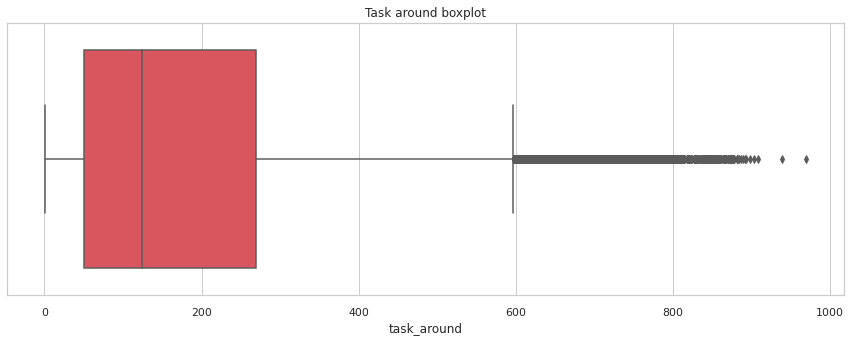

In [19]:
plt.figure(figsize=(15,5))
plt.tight_layout()
gts = sns.boxplot(x=df["task_around"] , color=PALETTE[1])
gts.set_title('Task around boxplot')

In [8]:
df["task_around"].describe()

count    226828.000000
mean        172.284780
std         147.929122
min           1.000000
25%          50.000000
50%         124.000000
75%         269.000000
max         970.000000
Name: task_around, dtype: float64

#### El feature task_around se traduce al número de tareas que tuvo una entrega en una ventana de tiempo de 3 horas con 3 kilómetros a la redonda, entonces la media se queda con 172 tareas a la redonda, la mitad de los registros han tenido hasta 124 tareas a la redonda y 3/4 de las entregas tuvieron hasta 269 tareas a las redonda. 

### Quitando outliers de task_around

In [14]:
task_around_abs_z_scores = np.abs(stats.zscore(df["task_around"]))
task_around_no_ot = df["task_around"][(task_around_abs_z_scores < 3)]

Text(0.5, 1.0, 'Task around boxplot')

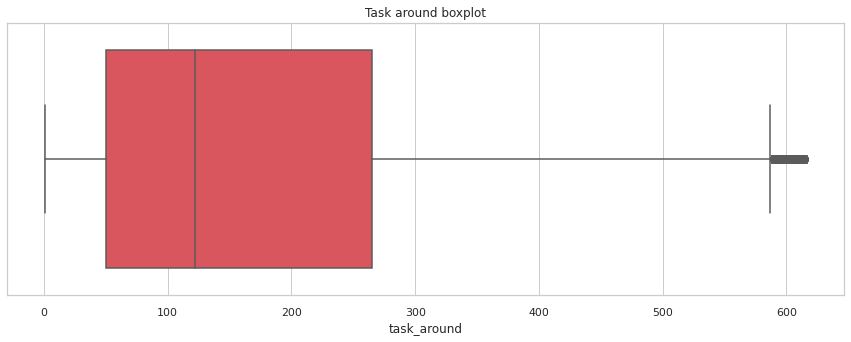

In [18]:
plt.figure(figsize=(15,5))
plt.tight_layout()
gts = sns.boxplot(x=task_around_no_ot, color=PALETTE[1])
gts.set_title('Task around boxplot')

In [16]:
task_around_no_ot.describe()

count    224772.000000
mean        167.367586
std         139.146117
min           1.000000
25%          50.000000
50%         122.000000
75%         265.000000
max         616.000000
Name: task_around, dtype: float64

#### El feature task_around se traduce al número de tareas que tuvo una entrega en una ventana de tiempo de 3 horas con 3 kilómetros a la redonda, entonces la media se queda con 172 tareas a la redonda, la mitad de los registros han tenido hasta 124 tareas a la redonda y 3/4 de las entregas tuvieron hasta 269 tareas a las redonda. 

### cost

Text(0.5, 1.0, 'Cost distribution')

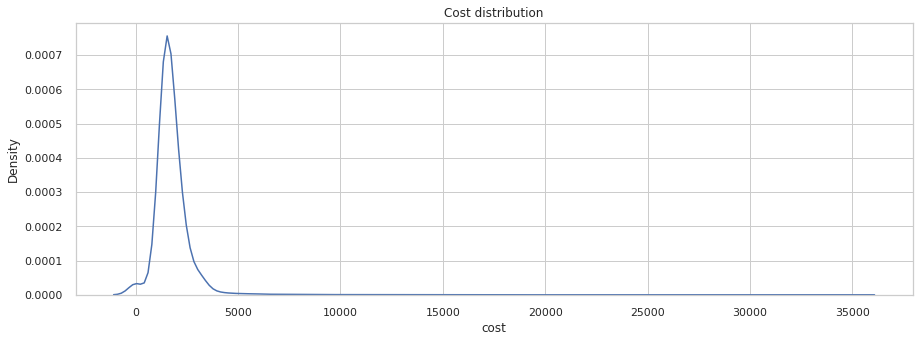

In [29]:
plt.figure(figsize=(15,5))
plt.tight_layout()
gts = sns.kdeplot(data=df, x='cost',palette=PALETTE, bw_adjust=5)
gts.set_title('Cost distribution')

In [20]:
df['cost'].describe()

count    226828.000000
mean       1752.800909
std         844.937686
min           0.000000
25%        1500.000000
50%        1500.000000
75%        2000.000000
max       35000.000000
Name: cost, dtype: float64

#### El feature cost se traduce al costo que tuvo una entrega. La media se queda con 844, la mitad de las entregas tuvieron un costo de hasta 1500 y 3/4 de las entregas tuvieron hasta de  2000. 

### Quitando outliers de cost

In [30]:
cost_abs_z_scores = np.abs(stats.zscore(df["cost"]))
cost_no_ot = df["cost"][(cost_abs_z_scores < 3)]

Text(0.5, 1.0, 'Cost distribution')

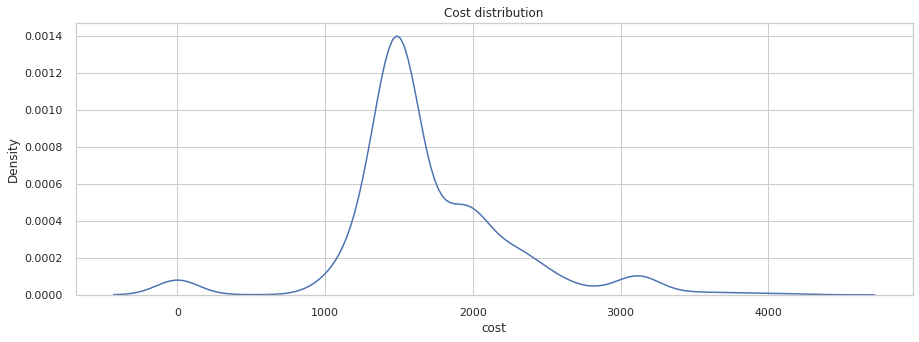

In [36]:
plt.figure(figsize=(15,5))
plt.tight_layout()
gts = sns.kdeplot(x=cost_no_ot, palette='muted', bw_adjust=3)
gts.set_title('Cost distribution')

In [37]:
cost_no_ot.describe()

count    224077.000000
mean       1691.082873
std         564.451210
min           0.000000
25%        1500.000000
50%        1500.000000
75%        2000.000000
max        4286.669922
Name: cost, dtype: float64

#### Cost sin outliers. La media se queda con 1691, la mitad de las entregas tuvieron un costo de hasta 1500 y 3/4 de las entregas tuvieron hasta de  2000. 

### Delta

Text(0.5, 1.0, 'Delta boxplot')

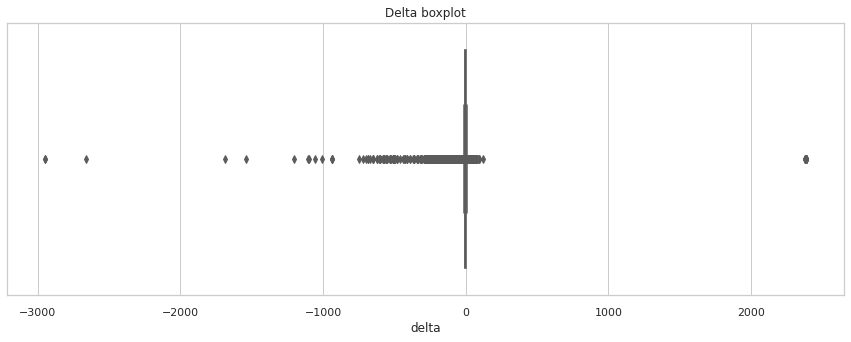

In [38]:
plt.figure(figsize=(15,5))
plt.tight_layout()
gts = sns.boxplot(x=df["delta"] , color=PALETTE[1])
gts.set_title('Delta boxplot')

In [39]:
df["delta"].describe()

count    226828.000000
mean         -3.702205
std          30.833342
min       -2947.410833
25%          -4.765069
50%          -1.624722
75%           0.425833
max        2386.768056
Name: delta, dtype: float64

#### El feature Delta se traduce como timpo de entrega planificado - tiempo de entrega real. La media se queda en -3.70 horas,  la mitad de entregas se realizaron hasta con 1.6 horas de anticipación y 3/4 de las entregas se entregan con un retraso máximo de 25 minutos. 

### Quitando outliers de task_around

In [43]:
delta_abs_z_scores = np.abs(stats.zscore(df["delta"]))
delta_no_ot = df["delta"][(cost_abs_z_scores < 3)]

Text(0.5, 1.0, 'Delta boxplot')

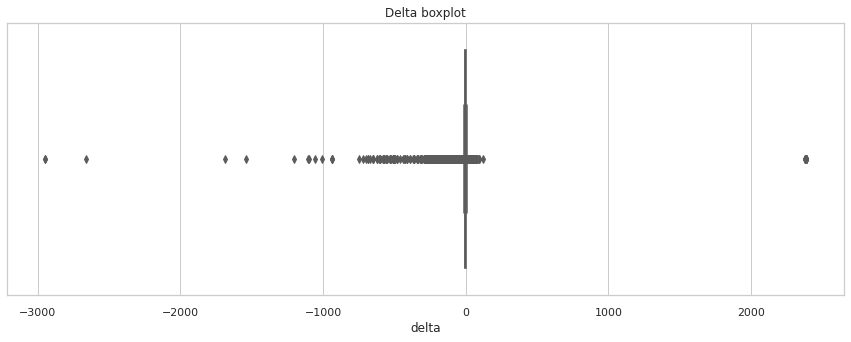

In [44]:
plt.figure(figsize=(15,5))
plt.tight_layout()
gts = sns.boxplot(x=delta_no_ot , color=PALETTE[1])
gts.set_title('Delta boxplot')

In [45]:
delta_no_ot.describe()

count    224077.000000
mean         -3.738011
std          31.010273
min       -2947.410833
25%          -4.809722
50%          -1.670556
75%           0.422778
max        2386.768056
Name: delta, dtype: float64

#### La media se queda en -3.73 horas,  la mitad de entregas se realizaron hasta con 1.66 horas de anticipación y 3/4 de las entregas se entregan con un retraso máximo de 25 minutos. 